# Introduction to simpleDAS

simpleDAS is python library that allow for simple reading, processing and saving of the ASN OptoDAS file format. 

The primary data container used is pandas dataframe that is extended to include meta data. The dataframe is a representation of a 2D numpy that allows for user specified labels on each column and row.  

SimpleDAS outputs a dataframe with channel numbers as column labels and timestamps as the row labels. In addition the returned dataframe includes additional metainformation obtained from the read files.

Note that the namespace has been changed from `simpleDASreader` to `simpledas`

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]
pd.options.display.max_rows = 8
pd.options.display.max_columns = 8
np.set_printoptions(threshold=20)
import scipy.signal as sps
import datetime
from IPython.display import display
import os

## Installing and importing 

The project structure has been modified in v 8.2 to satisfy the requirements for python packaging with [hatch](https://hatch.pypa.io/latest/). The code is moved to subdirectory src/simpledas.

The simplest way to import is to install with `pip` directly from git:  
`
pip install git+https://github.com/ASN-Norway/simpleDAS.git
`  
This code will install the simpledas along with other python packages in your python enviroment.

In [22]:
import simpledas
#from simpledas import simpleDASreader ## use legacy namespace simpleDASreader

## Reading DAS files

The OptoDAS files are read using function `load_DAS_files`.

In [23]:
help(simpledas.load_DAS_files)

Help on function load_DAS_files in module simpledas.simpleDASreader:

load_DAS_files(filepaths: 'str | list[str]', chIndex: 'None | slice | list[int] | np.ndarray' = None, samples: 'None | slice | int' = None, sensitivitySelect: 'int' = 0, integrate: 'bool' = True, unwr: 'bool' = False, spikeThr: 'None | float' = None, userSensitivity: 'None | dict' = None, useLabeledColumns: 'None | bool' = None, verbose: 'bool' = False) -> 'DASDataFrame'
    Loads OptoDAS recorded datafiles to pandas dataframe.
    
    
    Parameters
    ----------
    filepaths: string or list of strings
        Full path + filename of files to load.
    
    chIndex: 1d array, list, slice or None
        Channel indices to load.
        None => load all available channels (default).
    
    samples: slice, int, or None
        Time indices to read. When reading multiple files,
        the index counter continous into subsequent files.
        None  => load all available time samples (default).
        int   => L

The obligatory parameters to **load_DAS_files** are:  
**filepaths**: A list with full path to files to load.   
**chIndex**  : The channel indexes in the file to load. NB this is not the same as channel numbers as it depends on region of interest (ROI) parameters of the recording.   
**samples**  : A list or slice of the time sample indexes to be read.  

In addition there are some optional parameters:  
**sensitivitySelect**: The sensitivity value to convert data in the file (usually rad/m) to sensitivityUnit. The file format allows for multiple sensitivity factors, however currently only the sensitivity to strain is implemented. Default value is 0, which gives scaling to unit strain. Values -1 and -2 gives output in rad/m and rad, respectively.  
**integrate**: The data recorded by the instrument is phase rate. Default value True, which provide data in strain. False gives strain per second.  
**unwr,spikeThr**: Parameters to handle large stain rates, see doc.  
**userSensitivity**: User defined sensitivity. Dictionary that includes keys 'sensitivity' and 'sensitivityUnit'. Use sensitivitySelect=-3 to use this sensitivity.  
**useLabeledColumns**: Use channel labels as columns if available (labels does not exists for standard DAS measurements).

Example usage:

In [8]:
experiment_path = '/mnt/auto/testdata/FSI_Production/FrequencySweep'
#experiment_path = '/data/fsi/FSI_Production/FrequencySweep'

filepaths = [os.path.join(experiment_path,'20210531/dphi/054357.hdf5'),
            os.path.join(experiment_path,'20210531/dphi/054407.hdf5')]
print(filepaths)
chIndex = slice(0,1000,4) # slice is the array slicing operator
samples = slice(1000,10000)
dfdas = simpledas.load_DAS_files(filepaths, chIndex, samples,integrate=False,sensitivitySelect=-1)

['/mnt/auto/testdata/FSI_Production/FrequencySweep/20210531/dphi/054357.hdf5', '/mnt/auto/testdata/FSI_Production/FrequencySweep/20210531/dphi/054407.hdf5']


`load_DAS_files` return a `DASDataFrame` which is an extended `pandas.DataFrame` with  `datetime.datetime` timestamps as index and the channel number as columns. The timestamps are derived from the timestamp of the recording.  

In [9]:
display(type(dfdas))
display(dfdas)
display(dfdas.columns)
display(dfdas.index)


simpledas.simpleDASreader.DASDataFrame

,0,20,40,60,...,4920,4940,4960,4980
2021-05-31 05:43:57.972000,-37.183514,-4.167407,-2.795710,-16.123444,...,-3.251611,285.442566,-7.780746,8.964298
2021-05-31 05:43:57.972100,8.831629,1.641241,1.927688,20.186323,...,-2.326362,232.373474,-1.015520,-10.820905
2021-05-31 05:43:57.972200,67.709793,0.542034,3.253857,0.405354,...,2.216857,199.202560,11.786669,0.145659
2021-05-31 05:43:57.972300,110.203819,-2.596210,-2.911575,1.040764,...,-9.827634,164.389084,-9.023669,4.165143
...,...,...,...,...,...,...,...,...,...
2021-05-31 05:43:58.871600,83.690987,-0.149681,-2.542042,-2.466560,...,5.081546,-344.373138,13.572371,-2.899227
2021-05-31 05:43:58.871700,55.701607,1.909296,-1.142918,-10.459302,...,-5.912205,-351.896149,-3.336960,0.747671
2021-05-31 05:43:58.871800,7.984034,7.802249,0.015040,-2.438920,...,-6.108593,-341.442383,-7.966753,-5.351354
2021-05-31 05:43:58.871900,-30.192080,1.253477,-0.233007,-12.865552,...,-4.613630,-321.418396,11.628692,1.307490


Index([   0,   20,   40,   60,   80,  100,  120,  140,  160,  180,
       ...
       4800, 4820, 4840, 4860, 4880, 4900, 4920, 4940, 4960, 4980],
      dtype='int32', length=250)

DatetimeIndex(['2021-05-31 05:43:57.972000', '2021-05-31 05:43:57.972100',
               '2021-05-31 05:43:57.972200', '2021-05-31 05:43:57.972300',
               '2021-05-31 05:43:57.972400', '2021-05-31 05:43:57.972500',
               '2021-05-31 05:43:57.972600', '2021-05-31 05:43:57.972700',
               '2021-05-31 05:43:57.972800', '2021-05-31 05:43:57.972900',
               ...
               '2021-05-31 05:43:58.871000', '2021-05-31 05:43:58.871100',
               '2021-05-31 05:43:58.871200', '2021-05-31 05:43:58.871300',
               '2021-05-31 05:43:58.871400', '2021-05-31 05:43:58.871500',
               '2021-05-31 05:43:58.871600', '2021-05-31 05:43:58.871700',
               '2021-05-31 05:43:58.871800', '2021-05-31 05:43:58.871900'],
              dtype='datetime64[ns]', length=9000, freq='100000N')

The `DASDataFrame` also include an additonal member dictionary `.meta` that includes the most important metadata of the data.

**dfdas.meta** dict fields:  
> **fileVersion**: format version number of the input file  
> **time**: timestamp of first sample as a datetime.datetime object  
> **dx**: channel separation in m  
> **dt**: sample interval in s  
> **gaugeLength**: sensor gaugelength in m  
> **unit**: unit of data. Note that this is the unit after applying sensitivity, not the unit of the data in the file.  
> **sensitivities,sensitivityUnits**: sensitivities that can applied to data after reading. Note that this values are only available if data is returned as rad/m or rad (sensitivitySelect=-1 or -2).  
> **experiment**: Name of experiment.  
> **filepaths**: The paths to the files read.  

In [10]:
display(dfdas.meta)

{'dt': 0.0001,
 'dx': 1.0213001907746815,
 'gaugeLength': 10.213001907746815,
 'experiment': 'Demo',
 'dataType': 3,
 'dimensionRanges': {'dimension0': {'max': 8999,
   'min': 0,
   'size': 9000,
   'unitScale': 0.0001},
  'dimension1': {'max': array([4980], dtype=int32),
   'min': array([0], dtype=int32),
   'size': array([250]),
   'unitScale': 1.0213001907746815}},
 'dimensionUnits': array([b's', b'm'], dtype='|S1'),
 'dimensionNames': ['time', 'distance'],
 'name': 'Phase rate per distance',
 'sensorType': 'D',
 'fileVersion': 7,
 'time': datetime.datetime(2021, 5, 31, 5, 43, 57, 972000),
 'unit': 'rad/m/s',
 'sensitivities': array([[9362208.90109403]]),
 'sensitivityUnits': array(['rad/m/strain'], dtype='<U12'),
 'filepaths': ['/mnt/auto/testdata/FSI_Production/FrequencySweep/20210531/dphi/054357.hdf5',
  '/mnt/auto/testdata/FSI_Production/FrequencySweep/20210531/dphi/054407.hdf5'],
 'dimensionSizes': array([9000,  250])}

Note that the dataframe index does not include timezone information. The index is implicitly in UTC timezone. However, if you need to have an index that is timezone aware, this info can be added. This can be useful if it will be compared to other data that is timezone aware.

The code belows add utc timezone to the index. Note that in the printout, the dtype is changed from `datetime64[ns]` to `datetime64[ns, UTC]`.

Note that you cannot apply `.tz_localize` more than once. If you need to to change timezone use `.tz_convert`.

In [11]:
dfdas.index = dfdas.index.tz_localize(datetime.timezone.utc)
display(dfdas.index)

DatetimeIndex(['2021-05-31 05:43:57.972000+00:00',
               '2021-05-31 05:43:57.972100+00:00',
               '2021-05-31 05:43:57.972200+00:00',
               '2021-05-31 05:43:57.972300+00:00',
               '2021-05-31 05:43:57.972400+00:00',
               '2021-05-31 05:43:57.972500+00:00',
               '2021-05-31 05:43:57.972600+00:00',
               '2021-05-31 05:43:57.972700+00:00',
               '2021-05-31 05:43:57.972800+00:00',
               '2021-05-31 05:43:57.972900+00:00',
               ...
               '2021-05-31 05:43:58.871000+00:00',
               '2021-05-31 05:43:58.871100+00:00',
               '2021-05-31 05:43:58.871200+00:00',
               '2021-05-31 05:43:58.871300+00:00',
               '2021-05-31 05:43:58.871400+00:00',
               '2021-05-31 05:43:58.871500+00:00',
               '2021-05-31 05:43:58.871600+00:00',
               '2021-05-31 05:43:58.871700+00:00',
               '2021-05-31 05:43:58.871800+00:00',
            

## Finding DAS data

Often we want to extract data from a spesific timestamp rather than a spesific DAS files. The DAS is organized in 10 s files with a path structure as follows:
> /\<data root path\>/\<experiment name\>/\<YYYYmmdd\>/\<datatype name\>/\<HHMMSS\>.hdf5  

where \<YYYYmmdd\> is the date and \<HHMMSS\> is the time of the first sample in the file. The recording can be started on an arbitrary second, which means that last digit in the file name may be unknown. 

In order to extract data from a specific time stamp, the function **find_DAS_files** can be used.

The obligatory parameters to **find_DAS_files** are:  
**experiment_path**:File path containing DAS files. Should point to /\<data root path\>/\<experiment name\>/. Pointing directly to the directory containing the files is also supported.  
**start**:Start time of data to extract on format 'YYYYmmdd HHMMSS'. May also be datetime.datetime object.  
**duration**: Duration in seconds to be loaded. May also be datetime.timedelta object

In addition there are some optional parameters:  
**channels**: List of DAS channels to read. Also accept as slice(start_channel, stop_channel, step). Load all if None.  
**datatype**: Datatype name/subfolder to read. Usually 'dphi' (default) or 'proc'.      
**load_file_from_start**:It True, load from start of the file containing the start timestamp, else calculated to sampleno corresponing to start timestamp

Returns **filepaths, chIndex, samples** that can be directly used as input to **load_DAS_files**.

Example usage:

In [12]:
#%% Find input files from experiment input folder and time interval

start = datetime.datetime(2021, 5, 31, 5, 44, 0)
duration = datetime.timedelta(seconds=20)

# Request a subset of channels. The function below will inspect the file and 
# determine which channels exist in the file, returned as the chIndex variable
channels = np.arange(4000, 5000, 1)

filepaths, chIndex, samples = simpledas.find_DAS_files(experiment_path, start, duration,
                                                              channels=channels,load_file_from_start=False)
dfdas = simpledas.load_DAS_files(filepaths, chIndex, samples)

-- Header info file: 054357.hdf5 --
	Experiment:            Demo
	File timestamp:        2021-05-31 05:43:57
	Type of data:          Phase rate per distance, unit: rad/m/s
	Sampling frequency:    10000.00 Hz
	Data shape:            100000 samples x 1800 channels
	Gauge length:          10.2 m
	Sensitivities:         9.36e+06 rad/m/strain
	Regions of interest:   0:8995:5
	1000 channels requested:[4000 4001 4002 ... 4997 4998 4999]
	200 channels found:    [4000 4005 4010 ... 4985 4990 4995]
-----------------------------------


In [13]:
display(filepaths)
display(chIndex)
display(samples)

['/mnt/auto/testdata/FSI_Production/FrequencySweep/20210531/dphi/054357.hdf5',
 '/mnt/auto/testdata/FSI_Production/FrequencySweep/20210531/dphi/054407.hdf5',
 '/mnt/auto/testdata/FSI_Production/FrequencySweep/20210531/dphi/054417.hdf5']

array([800, 801, 802, ..., 997, 998, 999])

slice(21280, 221280, None)

## Using DASDataFrame

The DASDataFrame can be used as an ordinary Pandas DataFrame, and all functions applicable to Pandas DataFrame can be used on DASDataFrame. This include indexing based on row and column index or row and column labels, reindexing, concatination of data frames. In order to use functions that does not support data frames, only numpy array, the corresponding numpy array can be extracted using

```python
dasdata = dfdas.to_numpy()
```
or 
```python
dasdata = dfdas.values
```
The meta attribute includes additional information about the data. E.g. `dfdas.meta['dt']` field can be used to construct new time axis or frequency axis, while `dfdas.meta['dx']` can be used to construct and position axis is meter.

Matplotlib can be used for plotting. Pandas has its own plotting methods that uses matplotlib as backend, however this methods appears to be quite laggy, it is therefore better to call matplotlib directly.

Plotting a line plots for some channels:

Text(0, 0.5, 'strain')

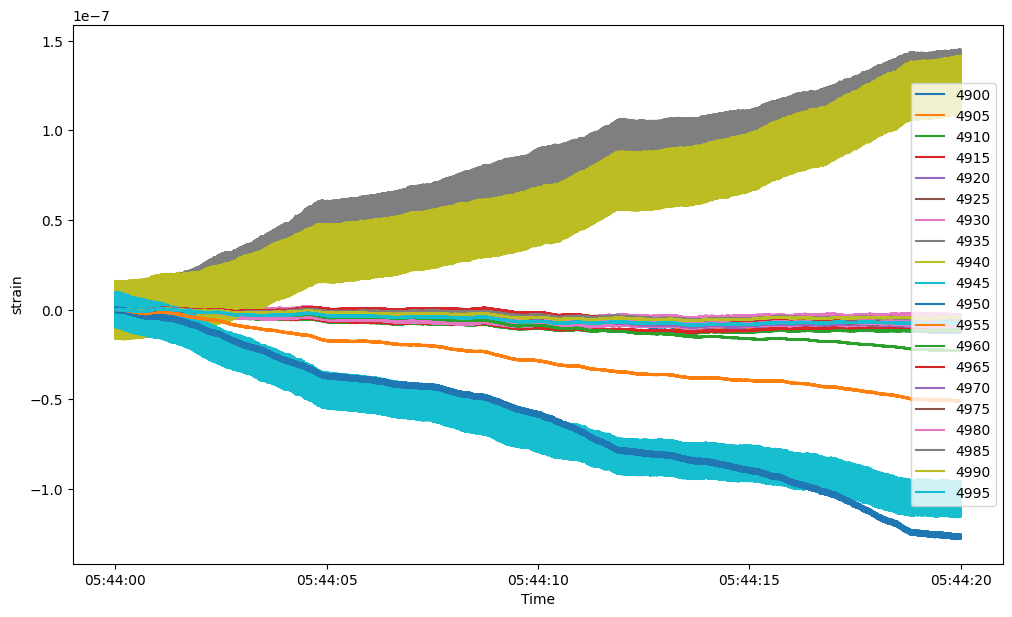

In [14]:
plt.figure(2,clear=True)
for ch in range(4900,5000,5):
    plt.plot(dfdas[ch], label=str(ch))
plt.legend()
plt.xlabel('Time')
plt.ylabel(dfdas.meta['unit'])

The `.loc`-method can be used to extract a subset in time and or position:

,4920,4925,4930,4935,...,4960,4965,4970,4975
2021-05-31 05:44:00.000000,-2.885528e-10,-2.389048e-10,4.657963e-10,4.839091e-09,...,-4.127059e-10,-1.900786e-10,-1.722195e-10,-2.089275e-10
2021-05-31 05:44:00.000100,-2.829752e-10,-2.779932e-10,1.263081e-09,7.627578e-09,...,-4.194278e-10,-1.834075e-10,-7.425140e-11,-1.657803e-10
2021-05-31 05:44:00.000200,-2.358652e-10,-2.375181e-10,1.842198e-09,9.652401e-09,...,-4.196019e-10,-2.805387e-10,-1.943670e-10,-9.861754e-11
2021-05-31 05:44:00.000300,-2.959229e-10,-2.565642e-10,2.251980e-09,1.134796e-08,...,-3.664340e-10,-7.034636e-11,3.729886e-11,-1.025054e-10
...,...,...,...,...,...,...,...,...,...
2021-05-31 05:44:02.999700,-6.436248e-11,-3.113329e-11,-1.999724e-09,-6.774656e-09,...,-7.095732e-11,-2.881366e-11,-1.042027e-10,-1.949278e-10
2021-05-31 05:44:02.999800,-1.651815e-10,8.645419e-11,-2.754347e-09,-9.662012e-09,...,1.448055e-11,8.724182e-11,-2.432645e-11,1.615572e-11
2021-05-31 05:44:02.999900,-1.008370e-11,5.339579e-11,-3.118709e-09,-1.061859e-08,...,-6.212344e-11,1.336383e-11,-3.042500e-11,-8.057684e-11
2021-05-31 05:44:03.000000,-4.360603e-11,1.194742e-10,-2.905112e-09,-1.001982e-08,...,3.743471e-11,-5.148033e-11,-1.242677e-10,-3.683541e-11


(18778.23888888889, 18778.238889004628)

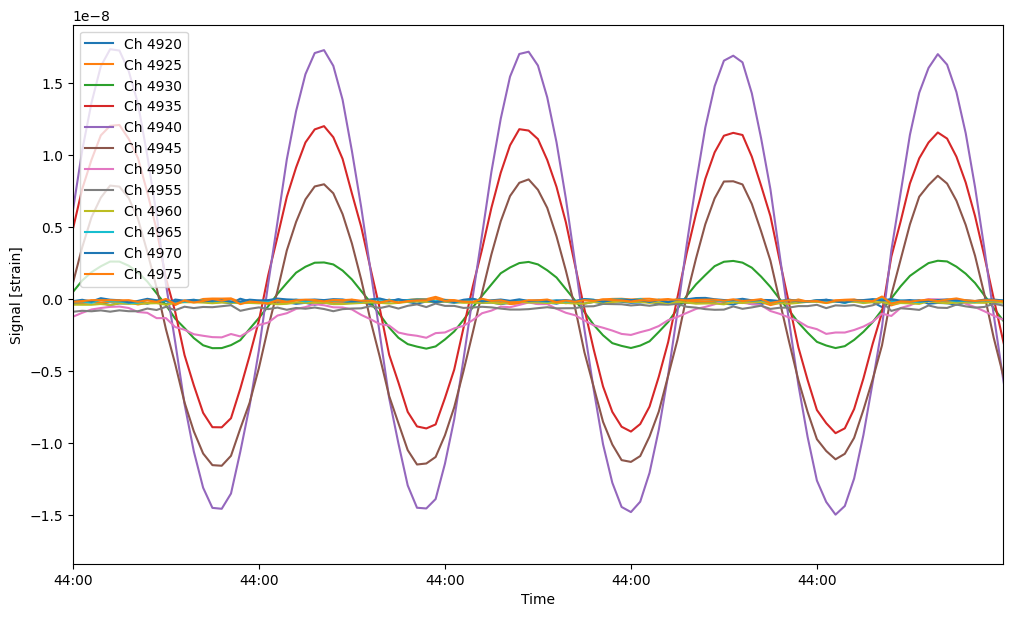

In [15]:
chs = np.arange(4920,4980,5)
dfdas_subset = dfdas.loc[:dfdas.index[0]+datetime.timedelta(seconds=3.),chs] #extract 3 s from start of ch 7500,8000,8500,9000 and 9500

#detrend data inplace
sps.detrend(dfdas_subset,axis=0,overwrite_data=True) 

#highpass filtering
sos = sps.butter(4,2,'highpass',output='sos',fs=1/dfdas_subset.meta['dt'])
filtout = sps.sosfilt(sos,dfdas_subset.values,axis=0)
dfdas_subset.loc[:,:] = filtout # replaceing data with filter result


display(dfdas_subset)
fig, ax = plt.subplots(1,1,clear=True,num=3)
ax.plot(dfdas_subset)
ax.legend(['Ch %d' %ch for ch in chs])
ax.set_xlabel('Time')
ax.set_ylabel('Signal [%s]' % dfdas.meta['unit'])

#modifying the format of the time axis
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%M:%S")) #shows only minutes and seconds
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3)) #Allow for less ticks on xaxis, default=5
ax.set_xlim([dfdas_subset.index[0],dfdas_subset.index[0]+datetime.timedelta(microseconds=10000)])

Sometimes it may be a bit cumbersome to use the datetime.datetime object as xaxis. However, the index be replaced by an index of floats in unit seconds.

,4920,4925,4930,4935,...,4960,4965,4970,4975
t,,,,,,,,,
0.0000,-1.248379e-11,-7.952943e-12,8.141174e-10,2.736970e-09,...,-1.369952e-10,-8.948604e-11,-1.262839e-10,-1.043340e-10
0.0001,-7.947312e-12,-4.797096e-11,1.614204e-09,5.546806e-09,...,-1.451551e-10,-8.343879e-11,-2.877676e-11,-6.187807e-11
0.0002,3.820670e-11,-8.424729e-12,2.198388e-09,7.600922e-09,...,-1.467809e-10,-1.813436e-10,-1.493904e-10,4.773688e-12
0.0003,-2.282969e-11,-2.836575e-11,2.614871e-09,9.331934e-09,...,-9.497980e-11,2.825982e-11,8.195998e-11,4.780908e-13
...,...,...,...,...,...,...,...,...,...
2.9997,-3.390817e-09,-2.789935e-09,-3.747754e-09,1.783597e-08,...,-2.519026e-09,-6.417884e-10,-2.113023e-09,-2.531927e-09
2.9998,-3.491650e-09,-2.671967e-09,-4.509634e-09,1.492345e-08,...,-2.433291e-09,-5.251510e-10,-2.033007e-09,-2.320767e-09
2.9999,-3.336477e-09,-2.704506e-09,-4.883104e-09,1.393534e-08,...,-2.509583e-09,-5.983772e-10,-2.038844e-09,-2.417234e-09
3.0000,-3.369724e-09,-2.637853e-09,-4.678877e-09,1.450194e-08,...,-2.409675e-09,-6.627968e-10,-2.132589e-09,-2.373315e-09


(1.0, 1.01)

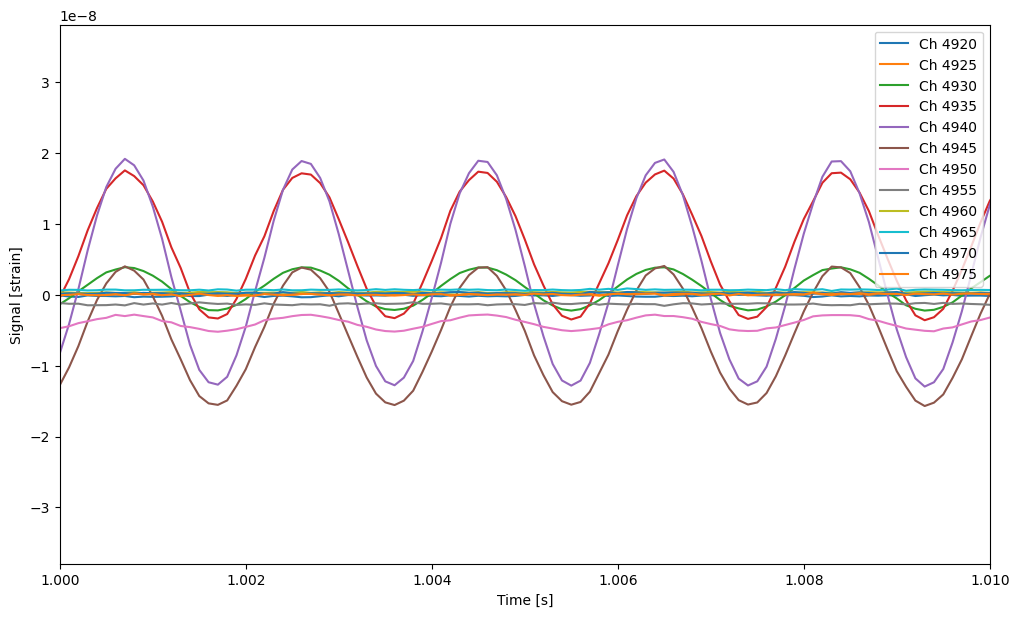

In [16]:
dfdas_tzero  = dfdas.loc[:dfdas.index[0]+datetime.timedelta(seconds=3.),chs] #extract 3 s from start of ch 7500,8000,8500,9000 and 9500
simpledas.convert_index_to_rel_time(dfdas_tzero)
display(dfdas_tzero)
fig, ax = plt.subplots(1,1,clear=True,num=3)
ax.plot(dfdas_tzero)
ax.legend(['Ch %d' %ch for ch in chs])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal [%s]' % dfdas.meta['unit'])
ax.set_xlim([1.0,1.01])

Another option is to call matplotlib with a separate argument for the time axis:

Text(0, 0.5, 'Signal [strain]')

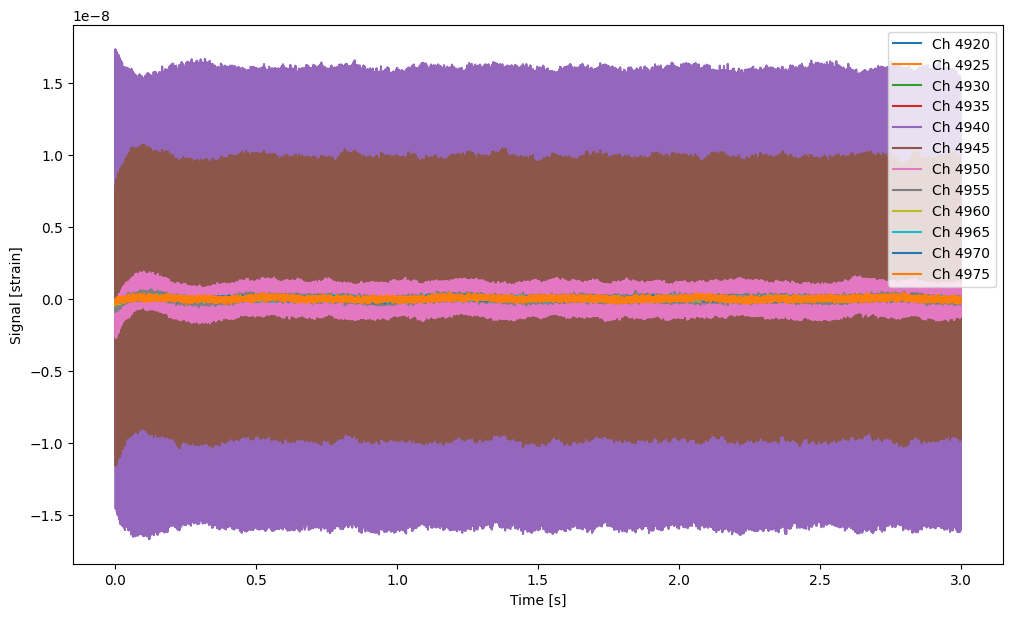

In [17]:
fig, ax = plt.subplots(1,1,clear=True,num=3)
t = np.arange(dfdas_subset.shape[0])*dfdas.meta['dt']
ax.plot(t,dfdas_subset)
ax.legend(['Ch %d' %ch for ch in chs])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal [%s]' % dfdas.meta['unit'])

Processing can be apply directly onto the dataframe object. The example below show an example of decimation with a decimated time index:

(1.0, 1.01)

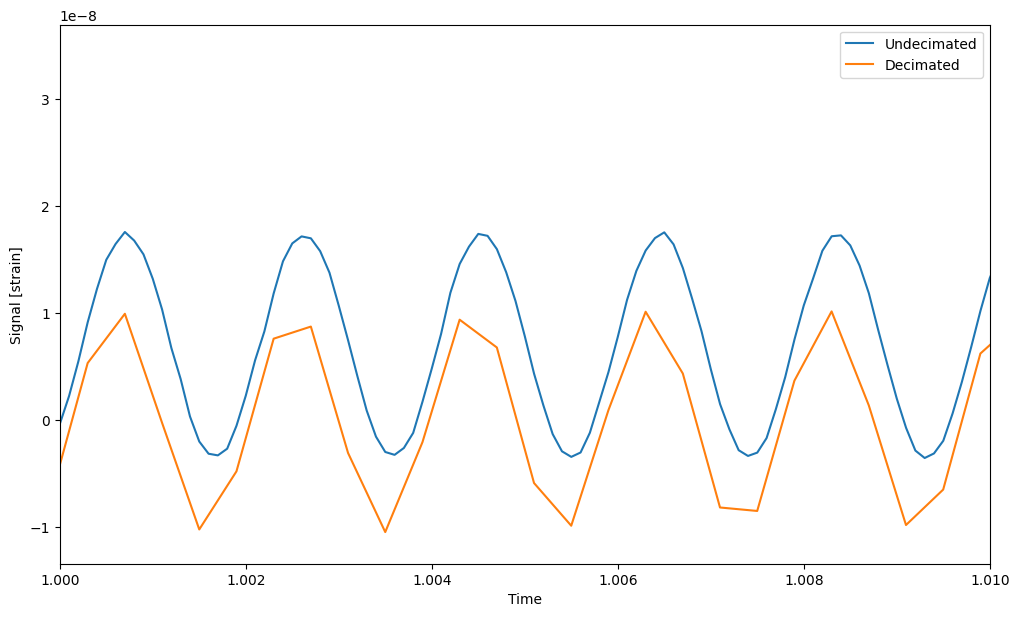

In [18]:
#%% decimate signal

decimation_factor = 4
Nt_in = dfdas_subset.shape[0]
# Alternative decimation methods. NB! these methods returns ndarray not DataFrame, even for DataFrame input
#sig_decimated = sps.resample(dfdas,Nt_in//decimation_factor) # resample in frequency domain
#sig_decimated = sps.decimate(dfdas, decimation_factor,ftype='fir',axis=0) # resample with filter
sig_decimated = sps.resample_poly(dfdas_subset,up=1,down=decimation_factor,axis=0,padtype='edge') # resample with polyphase filter implementation

Nt_out = sig_decimated.shape[0]
dt_out = dfdas.meta['dt']*Nt_in/Nt_out
tstart = dfdas.meta['time'] + datetime.timedelta(seconds=0) # may add a timeoffset to adjust for processing delay
# Time axis with absolute time:
#t = simpledas.create_time_axis(tstart,sig_decimated.shape[0],dt_out)
# or time axis relative time
t = np.arange(Nt_out)*dt_out # seconds from start of data
meta_out= dfdas.meta.copy()
meta_out.update(dt= dt_out,time=tstart)
dfdas_decimated = simpledas.DASDataFrame(sig_decimated,index=t,columns=dfdas_subset.columns,
                                               meta = meta_out)

fig,ax=plt.subplots(1,1,clear=True,num=3)
ax.plot(dfdas_tzero[4935],label='Undecimated')
ax.plot(dfdas_decimated[4935],label='Decimated')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Signal [%s]' % dfdas.meta['unit'])
ax.set_xlim([1.0,1.01])

## Saving data

A DASDataFrame can be saved as a DAS hdf5-file, that can be read by load_DAS_files. Only a subset of the original metadata is saved. The filename is derived from the timestamp:

In [19]:
help(simpledas.save_to_DAS_file)

Help on function save_to_DAS_file in module simpledas.simpleDASreader:

save_to_DAS_file(dfdas: 'DASDataFrame', filepath: 'None | str' = None, datatype: 'str' = 'processed', **auxmeta) -> 'tuple[str, dict]'
    Save a DASDataframe to file in a format that is readable for load_DAS_files.
    Note that just a small subset of the meta information from original files are
    kept.
    Useful when a preprocessing step is required where the intermediate result
    should be saved.
    
    In order to copy all meta data to output file:
    dfdas = load_DAS_files(filename)
    filemeta = get_filemeta(filename,2)
    ... processing dfdas ...
    save_to_DAS_file(dfdas,**filemeta)
    
    Parameters
    ----------
    dfdas : DASDataframe
        The dataframe to be saved
    filepath : str, optional
        The filepath to which the data is saved.
        If None, the data is save to a file derived from the start time
        dfdas.meta['time'] and datatype in the path with datatype input par

Saving with metadata sufficient to read back by simpledas:

In [20]:
filename_out = simpledas.save_to_DAS_file(dfdas_decimated)

Saving to file: /mnt/auto/testdata/FSI_Production/FrequencySweep/20210531/processed/054400.hdf5


Reloading the file:

In [21]:
filepaths, chIndex, samples = simpledas.find_DAS_files(experiment_path, start, duration,
                                                              channels=channels,datatype='processed')
dfdas_reloaded = simpledas.load_DAS_files(filepaths, chIndex, samples,integrate=False)

-- Header info file: 054400.hdf5 --
	Experiment:            Demo
	File timestamp:        2021-05-31 05:44:00
	Type of data:          Phase per distance, unit: strain
	Sampling frequency:    2500.25 Hz
	Data shape:            7501 samples x 12 channels
	Gauge length:          10.2 m
	Sensitivities:         1.00e+00 
	Regions of interest:   4920:4975:4
	1000 channels requested:[4000 4001 4002 ... 4997 4998 4999]
	12 channels found:    [4920 4925 4930 4935 4940 4945 4950 4955 4960 4965 4970 4975]
-----------------------------------
